# ProstMorph
MRI/US fusion using VoxelMorph

In [1]:
import itertools
from pathlib import Path

import SimpleITK as sitk
import neurite as ne
import numpy as np
import tensorflow as tf
import voxelmorph as vxm

from notebooks.utils import ImageLoader

tf.div_no_nan = tf.math.divide_no_nan

Load images and segmentations, then convert them to Numpy

In [22]:
base_folder = Path(r"R:\DATASET_PROSTATE")
patient, mr_data, us_data = "paziente1000", "Dato1", "Dato1"

# prepare filenames
mr_data_folder = base_folder / "mri" / patient / mr_data
us_data_folder = base_folder / "us" / patient / us_data
mr_image_filename = list(mr_data_folder.rglob("MRI*"))[0]
us_image_filename = list(us_data_folder.rglob("US*"))[0]
mr_prostate_filename = list(mr_data_folder.rglob("Prostate*"))[0]
us_prostate_filename = list(us_data_folder.rglob("Prostate*"))[0]
del mr_data_folder, us_data_folder

# load and crop
isotropic_spacing = [0.5, 0.5, 0.5]
cropping_size = [144, 144, 144]  # the paper uses [160, 192, 224]...
mr_image_cropped, mr_prostate_cropped, mr_image_nrrd, mr_prostate_nrrd = ImageLoader.load_image(mr_image_filename, mr_prostate_filename, isotropic_spacing, cropping_size)
us_image_cropped, us_prostate_cropped, us_image_nrrd, us_prostate_nrrd = ImageLoader.load_image(us_image_filename, us_prostate_filename, isotropic_spacing, cropping_size)
del mr_image_filename, us_image_filename, mr_prostate_filename, us_prostate_filename

### Data Inspection
Show the volumes (middle slices)

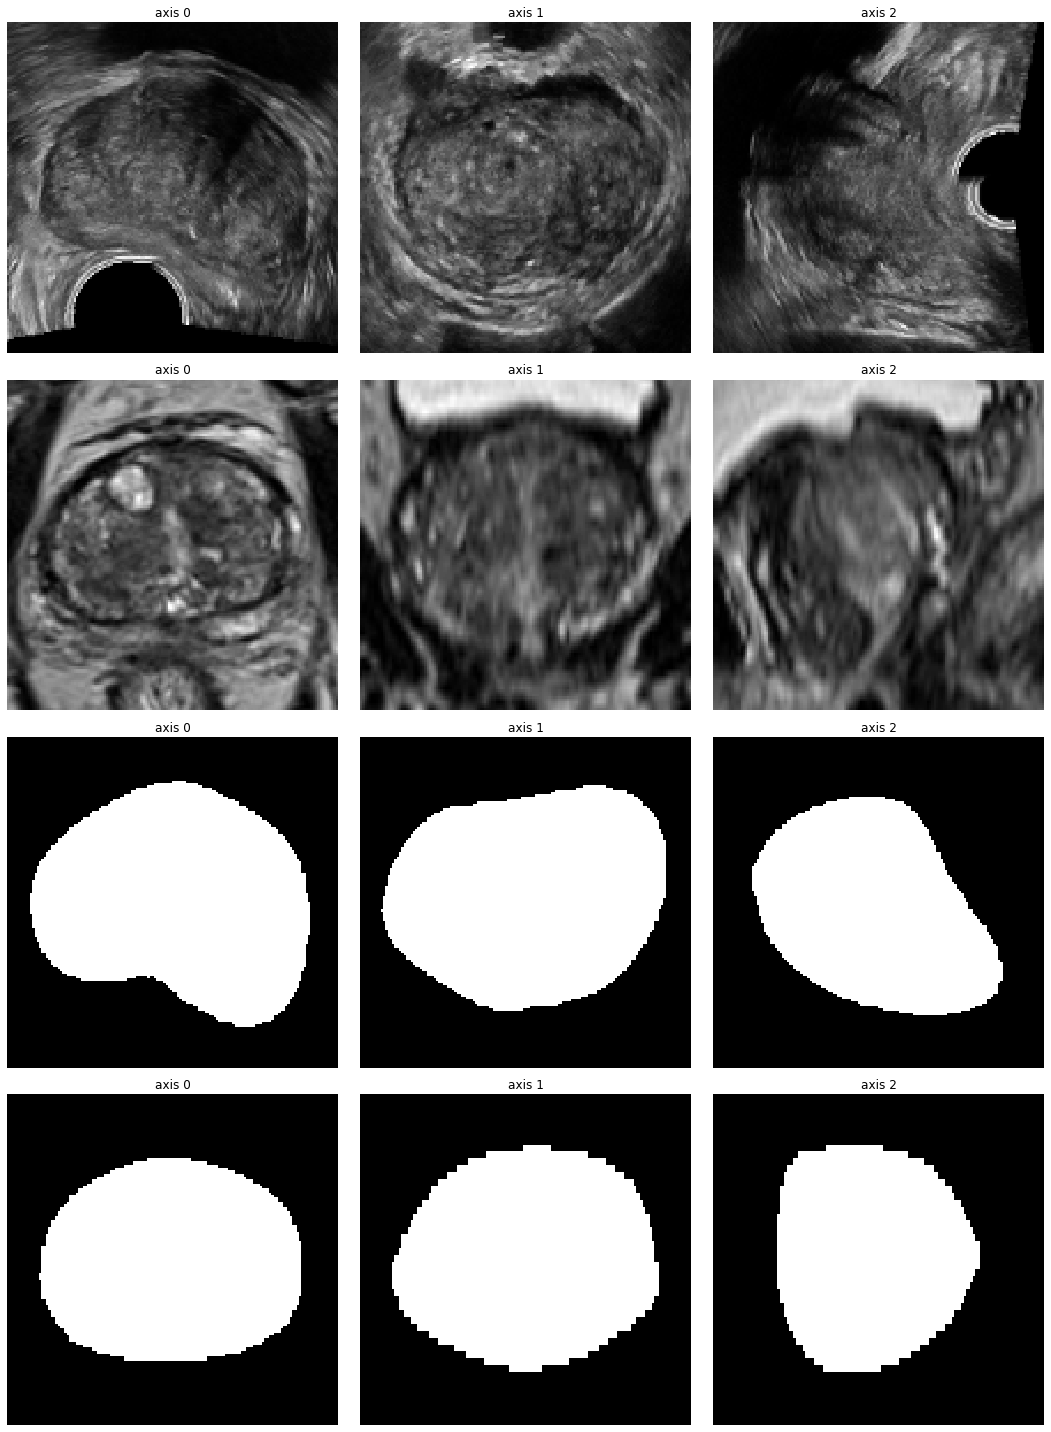

In [24]:
ne.plot.volume3D([us_image_cropped, mr_image_cropped, us_prostate_cropped, mr_prostate_cropped], cmaps=["gray"])

Open the images in 3D Slicer if needed

In [80]:
viewer = sitk.ImageViewer()
viewer.SetCommand("Slicer")
viewer.Execute(mr_image_nrrd)

Show 16 sagittal slices

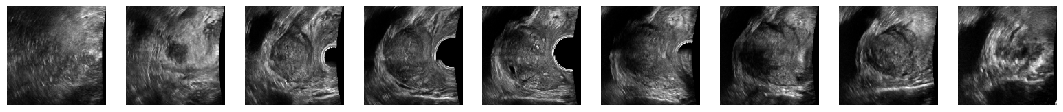

In [284]:
_ = ne.plot.slices([us_image_cropped[:,:,i] for i in range(0, us_image_cropped.shape[2], 16)], cmaps=["gray"])

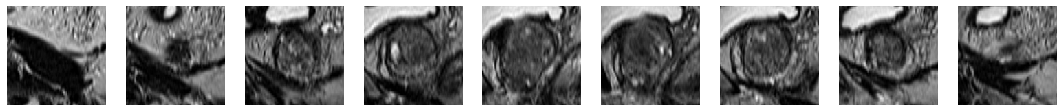

In [285]:
_ = ne.plot.slices([mr_image_cropped[:,:,i] for i in range(0, mr_image_cropped.shape[2], 16)], cmaps=["gray"])

### Build model
Setup the VoxelMorph network

In [3]:
def prepare_model(inshape, use_seg=True):
    if use_seg:
        vxm_model = vxm.networks.VxmDenseSemiSupervisedSeg(inshape=inshape, nb_labels=1, seg_downsize=1)
    else:
        vxm_model = vxm.networks.VxmDense(inshape=inshape)

    # histogram bins
    bin_centers = np.linspace(0, 1, 48)  # assume normalized images

    # assigning loss
    lambda_param = 0.05
    gamma_param = 0.01
    loss_weights = [1, lambda_param] \
                    + [gamma_param] if use_seg else []

    losses = [vxm.losses.NMI(bin_centers=bin_centers, vol_size=inshape, local=False).loss, vxm.losses.Grad('l2').loss] \
                    + [vxm.losses.Dice().loss] if use_seg else []

    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=losses, loss_weights=loss_weights)
    return vxm_model

class SmartDataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras"""
    def __init__(self, data_paths, batch_size=32, shuffle=True):
        """Initialization"""
        self.dim = (128, 128, 128)
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.patients_cases = data_paths

        self.indexes = np.arange(len(self.patients_cases))
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.patients_cases) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        patients_list = [self.patients_cases[k] for k in indexes]

        # Generate data
        inputs, outputs = self.__data_generation(patients_list)

        return inputs, outputs

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, patients_list):
        """Generates data containing batch_size samples"""
        # X : (n_samples, *dim, n_channels)
        moving_images = np.zeros(shape=(self.batch_size, *self.dim))
        fixed_images = np.zeros(shape=(self.batch_size, *self.dim))
        moving_images_seg = np.zeros(shape=(self.batch_size, *self.dim))
        fixed_images_seg = np.zeros(shape=(self.batch_size, *self.dim))
        zero_phi = np.zeros(shape=(self.batch_size, *self.dim, len(self.dim)))

        # Generate data
        for i, data_path in enumerate(patients_list):
            mr_image_cropped, mr_prostate_cropped, us_image_cropped, us_prostate_cropped = SmartDataGenerator.single_load(data_path)
            # images need to be of the size [batch_size, H, W, D]
            moving_images[i, ...] = mr_image_cropped
            fixed_images[i, ...] = us_image_cropped
            moving_images_seg[i, ...] = mr_prostate_cropped
            fixed_images_seg[i, ...] = us_prostate_cropped
            # print(f"(loaded {data_path.name})")

        inputs = [moving_images, fixed_images, moving_images_seg]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi, fixed_images_seg]

        return inputs, outputs

    @staticmethod
    def single_load(path):
        data = np.load(path)
        mr_image, mr_prostate = data['mr_image'], data['mr_seg']
        us_image, us_prostate = data['us_image'], data['us_seg']
        return mr_image, mr_prostate, us_image, us_prostate

    @staticmethod
    def single_input(path):
        mr_image, mr_prostate, us_image, us_prostate = SmartDataGenerator.single_load(path)
        return [mr_image, us_image, mr_prostate]

class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras"""
    def __init__(self, dataset_path: Path, batch_size=32, dim=(32, 32, 32), shuffle=True, resampling_spacing=(1.0, 1.0, 1.0), use_seg=True):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.folder_base = dataset_path
        self.folder_mr = self.folder_base / "mri"
        self.folder_us = self.folder_base / "us"
        self.resampling_spacing = resampling_spacing
        self.use_seg = use_seg

        patients_us_list = [f.name for f in self.folder_us.iterdir()]
        patients_list = [f.name for f in self.folder_mr.iterdir() if f.name in patients_us_list]
        self.patients_options = [
            (p, mr, us)
            for p in patients_list
            for mr, us in list(itertools.product([f.name for f in (self.folder_mr / p).iterdir()], [f.name for f in (self.folder_us / p).iterdir()]))
        ]

        self.indexes = np.arange(len(self.patients_options))
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.patients_options) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        patients_list = [self.patients_options[k] for k in indexes]

        # Generate data
        inputs, outputs = self.__data_generation(patients_list)

        return inputs, outputs

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, patients_list):
        """Generates data containing batch_size samples"""
        # X : (n_samples, *dim, n_channels)
        moving_images = np.zeros(shape=(self.batch_size, *self.dim))
        fixed_images = np.zeros(shape=(self.batch_size, *self.dim))
        moving_images_seg = np.zeros(shape=(self.batch_size, *self.dim))
        fixed_images_seg = np.zeros(shape=(self.batch_size, *self.dim))
        zero_phi = np.zeros(shape=(self.batch_size, *self.dim, len(self.dim)))

        # Generate data
        for i, (patient, mr_data, us_data) in enumerate(patients_list):
            mr_image_filename = list((self.folder_mr / patient / mr_data).rglob("MRI*"))[0]
            us_image_filename = list((self.folder_us / patient / us_data).rglob("US*"))[0]
            mr_prostate_filename = list((self.folder_mr / patient / mr_data).rglob("Prostate*"))[0]
            us_prostate_filename = list((self.folder_us / patient / us_data).rglob("Prostate*"))[0]
            mr_image_cropped, mr_prostate_cropped, _, _ = ImageLoader.load_image(mr_image_filename, mr_prostate_filename, self.resampling_spacing, self.dim)
            us_image_cropped, us_prostate_cropped, _, _ = ImageLoader.load_image(us_image_filename, us_prostate_filename, self.resampling_spacing, self.dim)

            # images need to be of the size [batch_size, H, W, D]
            moving_images[i, ...] = mr_image_cropped
            fixed_images[i, ...] = us_image_cropped
            moving_images_seg[i, ...] = mr_prostate_cropped
            fixed_images_seg[i, ...] = us_prostate_cropped

            print(f"(loaded {patient})")

        inputs = [moving_images, fixed_images] + [moving_images_seg] if self.use_seg else []

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi] + [fixed_images_seg] if self.use_seg else []

        return inputs, outputs

Create dataset generators

In [11]:
# base_folder = Path(r"R:\DATASET_PROSTATE")
# # train_generator = DataGenerator(base_folder, batch_size=1, dim=resample_dim, resampling_spacing=(0.5, 0.5, 0.5), use_seg=True)

train_test_split = 0.9
train_val_split = 0.8

base_folder = Path(r"R:\DATASET_PROSTATE\numpy")
full_data = np.array(list(base_folder.iterdir()))
np.random.shuffle(full_data)
idx = (np.array([train_test_split * train_val_split, train_test_split]) * full_data.shape[0]).astype(int)
train_data, validation_data, test_data = np.split(full_data, idx)
del idx

train_generator = SmartDataGenerator(train_data, batch_size=1)
validation_generator = SmartDataGenerator(validation_data, batch_size=1)
test_generator = SmartDataGenerator(test_data, batch_size=1)

Instantiate network

In [12]:
resample_dim = (128, 128, 128)
nb_epochs = 100
steps_per_epoch = 100

In [13]:
model = prepare_model(inshape=resample_dim, use_seg=True)

vxm info: mutual information loss is experimental


In [ ]:
model.summary(line_length=160)

Train network

In [14]:
hist = model.fit(
    train_generator, validation_data=validation_generator,
    epochs=nb_epochs, steps_per_epoch=steps_per_epoch, initial_epoch=0,
    # use_multiprocessing=True, workers=4,
    verbose=2
)

Epoch 1/100
100/100 - 341s - loss: -4.5328e-02 - transformer_loss: -4.2577e-02 - flow_resize_loss: 9.8293e-05 - seg_transformer_loss: -2.7566e-01 - val_loss: -4.6802e-02 - val_transformer_loss: -4.4040e-02 - val_flow_resize_loss: 2.4610e-04 - val_seg_transformer_loss: -2.7737e-01 - 341s/epoch - 3s/step
Epoch 2/100
100/100 - 285s - loss: -4.5598e-02 - transformer_loss: -4.2864e-02 - flow_resize_loss: 2.8549e-04 - seg_transformer_loss: -2.7485e-01 - val_loss: -4.7033e-02 - val_transformer_loss: -4.4281e-02 - val_flow_resize_loss: 4.3976e-04 - val_seg_transformer_loss: -2.7744e-01 - 285s/epoch - 3s/step
Epoch 3/100
100/100 - 285s - loss: -4.9204e-02 - transformer_loss: -4.6650e-02 - flow_resize_loss: 0.0050 - seg_transformer_loss: -2.8029e-01 - val_loss: -5.2065e-02 - val_transformer_loss: -5.0816e-02 - val_flow_resize_loss: 0.0320 - val_seg_transformer_loss: -2.8504e-01 - 285s/epoch - 3s/step
Epoch 4/100
100/100 - 286s - loss: -5.7073e-02 - transformer_loss: -5.8520e-02 - flow_resize_los

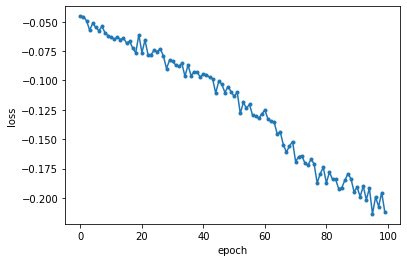

In [15]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

In [16]:
test_input, _ = test_generator[0]
test_pred = model.predict(test_input)

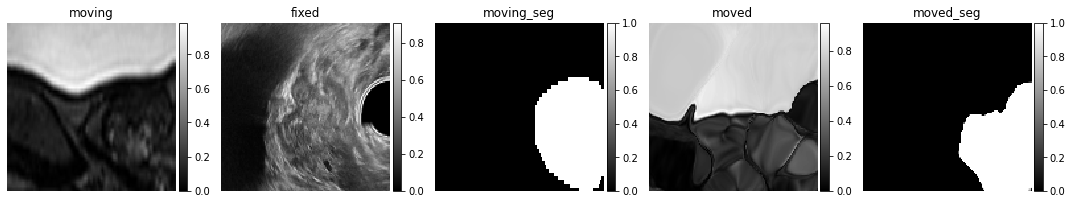

In [17]:
images = [img[0, :, :, 60].squeeze() for img in [test_input[0], test_input[1], test_input[2], test_pred[0], test_pred[2]]]
titles = ['moving', 'fixed', 'moving_seg', 'moved', 'moved_seg']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

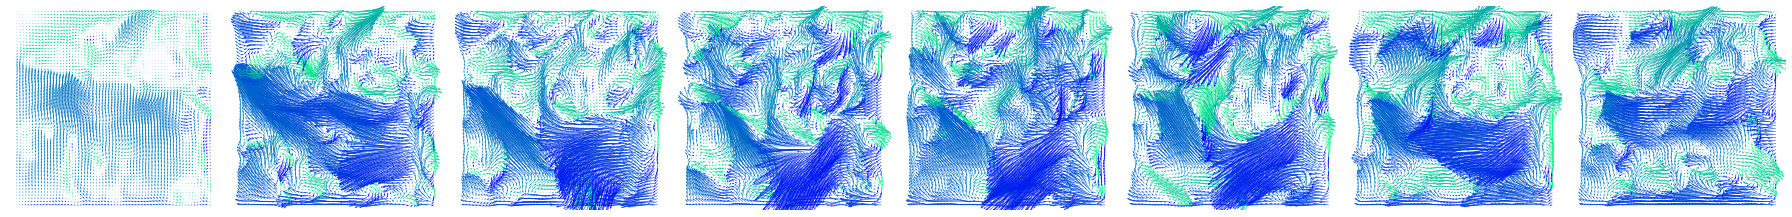

In [52]:
flow = test_pred[1].squeeze()
_ = ne.plot.flow([flow[:, :, i, [0,1]] for i in range(0, 64, 8)], width=25)